In [1]:
# Load the following packages
import pandas as pd 

#for removing outliers
from pyod.models.ecod import ECOD

#for scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer

#for plotting
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns  #heatmaps

#for clustering model
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import euclidean_distances

#pca plots
from sklearn.decomposition import PCA, FactorAnalysis

In [2]:
#load data
df_sp = pd.read_csv(r'Lizdat.csv')
df_fac = pd.read_csv(r'Lizfac.csv')

# Cluster analysis

The cluster analysis is going to group all the transects based on the fact that they have a similar benthic composition.

## Step 1 Data preperation

Cluster analysis is sensitive to outliers so they need to be removed prier to running the model. In the data we have some biota that are classified into a broad taxanomic group such as "sponge" and other biota that are seperated into higher taxanomic classifications such as branching acropora. We therefore want to scale each taxa so that all taxa have the similar weightings. 

### Step 1.1 Remove outliers

In [3]:
#Locate outlier transects
clf = ECOD()
clf.fit(df_sp)
outliers = clf.predict(df_sp) 

df_sp["outliers"] = outliers

#Remove outliers from species data
df_sp_nout = df_sp[df_sp["outliers"] == 0]
df_sp_nout = df_sp_nout.drop(["outliers"], axis = 1)
df_sp_nout = df_sp_nout.reset_index(drop=True)


#Remove outliers from factors data
df_fac_out = df_fac
df_fac_out["outliers"] = df_sp["outliers"]
df_fac_nout = df_fac_out[df_fac_out["outliers"] == 0]
df_fac_nout = df_fac_nout.drop(["outliers"], axis = 1)
df_fac_nout = df_fac_nout.reset_index(drop=True)

#To see how many outlier samples were removed from the data
print(f"Number of outlier samples: {df_sp.shape[0] - df_sp_nout.shape[0]}")

Number of outlier samples: 30


### Step 1.2 Scale the data

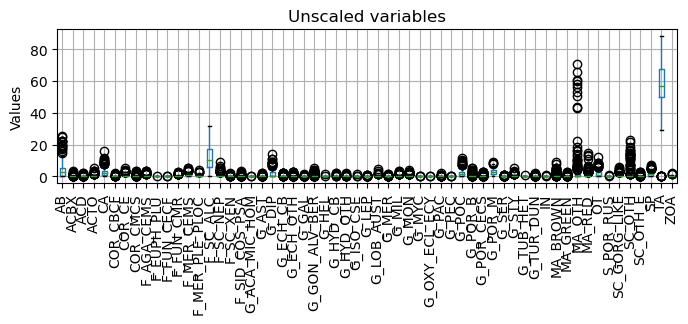

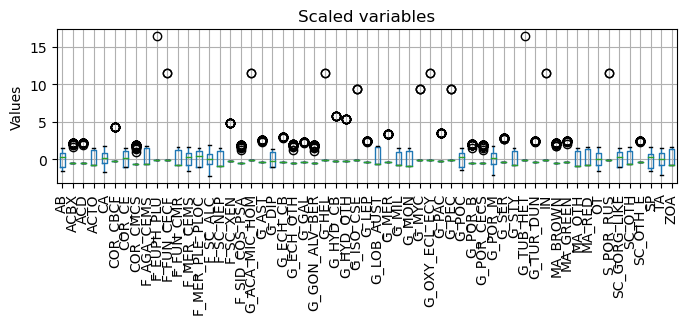

In [4]:
#Scaling variables
pipe = Pipeline([('ordinal', OrdinalEncoder()), ('scaler', PowerTransformer())])
pipe_fit = pipe.fit(df_sp_nout)

df_sp_scaled = pd.DataFrame(pipe_fit.transform(df_sp_nout), columns = df_sp_nout.columns)

#unscaled data
df_sp_nout.boxplot(figsize=(8, 2), rot=90)
plt.title('Unscaled variables')
plt.ylabel('Values')
plt.show()

#scaled data
df_sp_scaled.boxplot(figsize=(8, 2), rot=90)
plt.title('Scaled variables')
plt.ylabel('Values')
plt.show()

### Step 1.3 Decide which variables to use

In [5]:
#remove unwanted columnsm, for example other organisms and indeterminate organisms
df_sp_scaled = df_sp_scaled.drop(columns=['OT', 'IN'])


## Step 2 Cluster model 

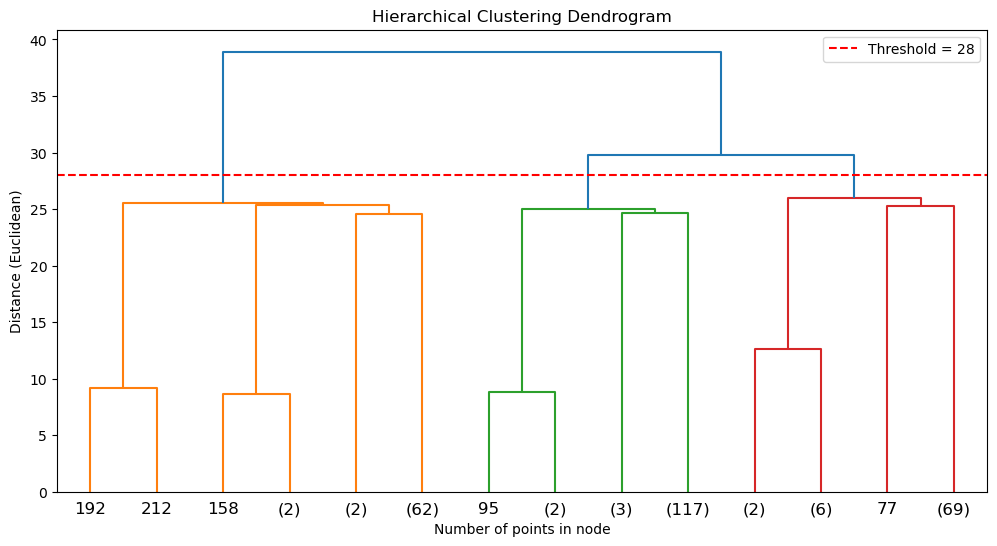

In [6]:
# Fit the AgglomerativeClustering model
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(df_sp_scaled)

# Compute the linkage matrix using the 'ward' method (you can change this method if needed)
linkage_matrix = linkage(df_sp_scaled, method='ward', metric='euclidean')

# Plot the corresponding dendrogram
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
dendrogram(linkage_matrix, truncate_mode="level", p=3) #adjust truncate_mode and p value to see more detail within the dendogram
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node")
plt.ylabel("Distance (Euclidean)")


threshold = 28  # You can adjust this threshold as needed
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()

plt.show()

# Add a cluster variable to the original dataframe based on a threshold
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
data_with_clusters = pd.concat([df_sp_scaled, pd.DataFrame({'Cluster': clusters})], axis=1)
fac_with_clusters = pd.concat([df_fac_nout, pd.DataFrame({'Cluster': clusters})], axis=1)

## Step 2.1 Selecting optimum number of clusters

For agglomerative clustering we use a dendogram to determine the appropatroate number of clusters. In the dendorgam it looks like there are three main clusters. We can also check this using the elbow plot, however there is no function to do this with aglomerative clustering so we use kmeans. 

C:\Users\kate whitton\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kate whitton\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kate whitton\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kate whitton\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Wind

C:\Users\kate whitton\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kate whitton\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kate whitton\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kate whitton\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Wind

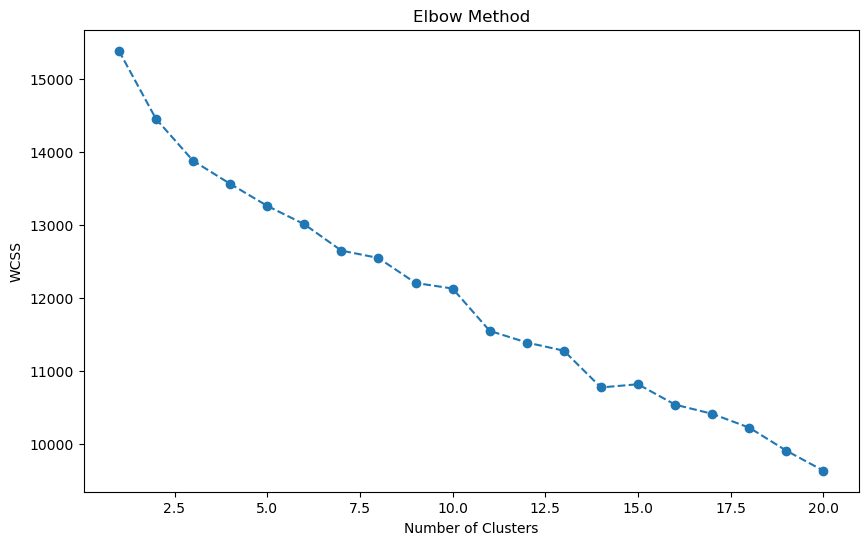

In [7]:

# WCSS (Within-Cluster-Sum-of-Squares) function
def calculate_wcss(df_sp_scaled, k_max=20):
    wcss = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(df_sp_scaled)
        wcss.append(kmeans.inertia_)
    return wcss

# Plotting the elbow curve
def plot_elbow(wcss, k_max=20):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, k_max + 1), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

# Calculate WCSS for different values of k
k_max_clusters = 20  # You can adjust this based on your needs
wcss_values = calculate_wcss(df_sp_scaled, k_max=k_max_clusters)

# Plot the elbow curve
plot_elbow(wcss_values, k_max=k_max_clusters)

# Step 2.2 Looking for patterns of benthic clusters 

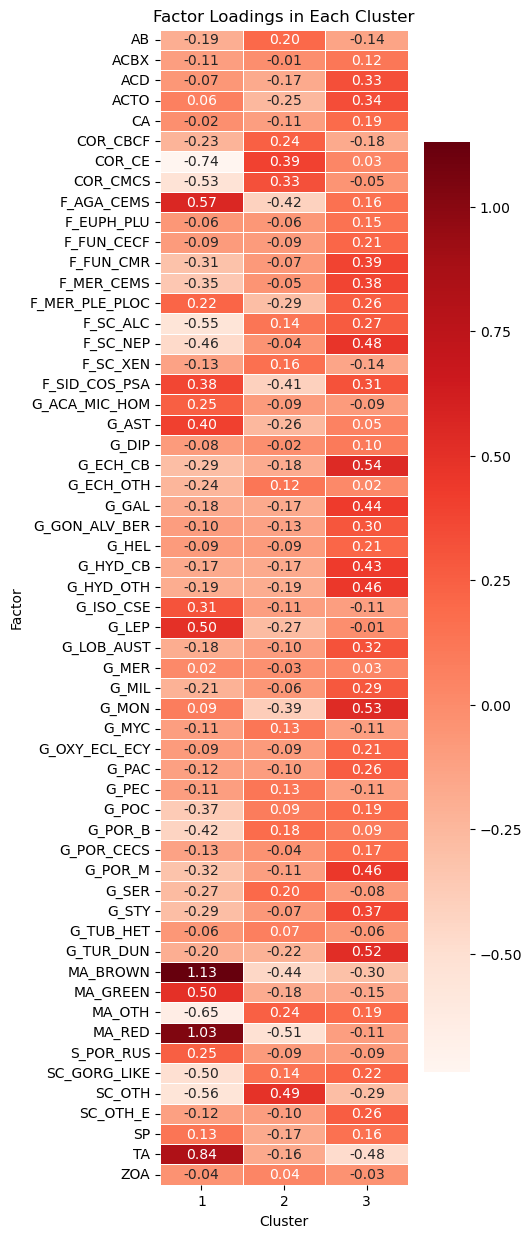

In [8]:
# heatmap by year

# Now, let's visualize how the factors are loaded onto each cluster
cluster_factors = data_with_clusters.groupby('Cluster').mean()
maincluster = cluster_factors.loc[cluster_factors.index.isin([1, 2, 3, 4])]

# Create a heatmap to visualize factor loadings in each cluster
plt.figure(figsize=(4, 15))
sns.heatmap(maincluster.T, cmap='Reds', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Factor Loadings in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Factor')
plt.savefig('heatmap_3clust.jpg', bbox_inches='tight')
plt.show()

In [9]:
# to test which species are associated with each cluster
# Assuming 'data2' is your DataFrame
for index, row in cluster_factors.iterrows():
    sorted_values = sorted(zip(row.index, row.values), key=lambda x: x[1], reverse=True)
    
    # Show only the top 8 values
    top_values = sorted_values[:8]
    
    print(f'\nTop 8 values for Row {index + 1}:')
    for column, value in top_values:
        print(f'Species: {column}, Mean: {value}')


Top 8 values for Row 2:
Species: MA_BROWN, Mean: 1.1291172331221104
Species: MA_RED, Mean: 1.0293585530461231
Species: TA, Mean: 0.8352104203995783
Species: F_AGA_CEMS, Mean: 0.5657146656768783
Species: MA_GREEN, Mean: 0.4986097463229992
Species: G_LEP, Mean: 0.49522077743072496
Species: G_AST, Mean: 0.40038778921440193
Species: F_SID_COS_PSA, Mean: 0.3759393131766458

Top 8 values for Row 3:
Species: SC_OTH, Mean: 0.493864887632717
Species: COR_CE, Mean: 0.39379614622770487
Species: COR_CMCS, Mean: 0.32563528803684244
Species: MA_OTH, Mean: 0.2429002501374329
Species: COR_CBCF, Mean: 0.24281547774037815
Species: G_SER, Mean: 0.20070460633496795
Species: AB, Mean: 0.19609923081258132
Species: G_POR_B, Mean: 0.18281289387043215

Top 8 values for Row 4:
Species: G_ECH_CB, Mean: 0.5436737460329623
Species: G_MON, Mean: 0.5335307805903796
Species: G_TUR_DUN, Mean: 0.5180678041523672
Species: F_SC_NEP, Mean: 0.4777758965673637
Species: G_HYD_OTH, Mean: 0.4570962170512051
Species: G_POR_M, 

In [10]:
#cluster_factors
# Get the top 8 column names with the largest values for row 1, row 2, and row 3
top_8_c1 = cluster_factors.iloc[0].nlargest(8).index.tolist()
top_8_c2 = cluster_factors.iloc[1].nlargest(8).index.tolist()
top_8_c3 = cluster_factors.iloc[2].nlargest(8).index.tolist()

# Combine column names into a single list to use later
top_8species = top_8_c1 + top_8_c2 + top_8_c3

top_8species

['MA_BROWN',
 'MA_RED',
 'TA',
 'F_AGA_CEMS',
 'MA_GREEN',
 'G_LEP',
 'G_AST',
 'F_SID_COS_PSA',
 'SC_OTH',
 'COR_CE',
 'COR_CMCS',
 'MA_OTH',
 'COR_CBCF',
 'G_SER',
 'AB',
 'G_POR_B',
 'G_ECH_CB',
 'G_MON',
 'G_TUR_DUN',
 'F_SC_NEP',
 'G_HYD_OTH',
 'G_POR_M',
 'G_GAL',
 'G_HYD_CB']

In [11]:
#add a variable based on site and transect 
#code transects 1 to 15
fac_with_clusters['sample'] = fac_with_clusters['Site'].astype(str) + fac_with_clusters['Transect'].astype(str) 
# Replace values '22' with '6' and '21' with '7' in the 'sample' column
fac_with_clusters['sample'] = fac_with_clusters['sample'].replace({'11': '1', '12': '2', '13': '3', '14': '4', '15': '5', '21': '6', '22': '7', '23': '8', '24': '9', '25': '10', '31': '11', '32': '12', '33': '13', '34': '14', '35': '15'})
fac_with_clusters['sample'] = fac_with_clusters['sample'].astype(int)

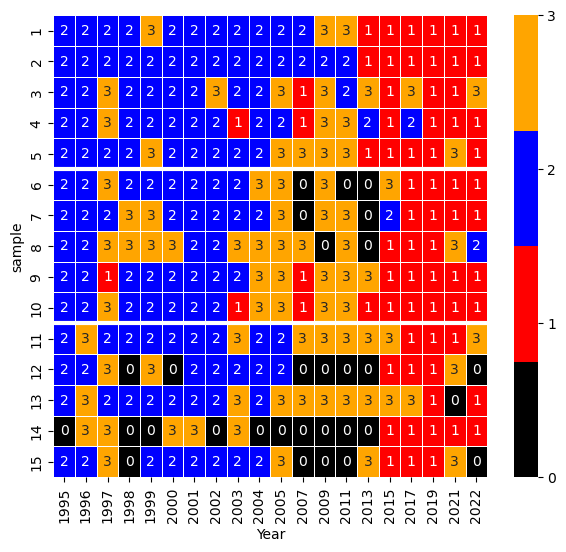

In [12]:
# Mapping cluster values to colors
cluster_colors = {0: 'black', 1: 'red', 2: 'blue', 3: 'orange'}

# Create a custom colormap using the specified colors
cluster_cmap = sns.color_palette([cluster_colors[i] for i in sorted(cluster_colors.keys())])

heatmap_data = fac_with_clusters.pivot(index='sample', columns='Year', values='Cluster')
heatmap_data = heatmap_data.fillna(0)  # Fill NaN with 0 and convert to int

# Convert the entire DataFrame to integer type
heatmap_data = heatmap_data.astype(int)

plt.figure(figsize=(7, 6))

# Use the custom colormap to assign colors to each category in 'Cluster'
sns.heatmap(heatmap_data, annot=True, fmt='g', linewidths=0.5, cmap=cluster_cmap, vmin=0, vmax=3, 
            cbar_kws={'ticks': range(heatmap_data.min().min(), heatmap_data.max().max() + 1)})

# Add horizontal lines between rows 5 and 6, and rows 10 and 11
plt.axhline(5, color='white', linewidth=3)
plt.axhline(10, color='white', linewidth=3)

# Save the plot as a JPEG file
plt.savefig('3heatmap_yr_sample_cluster.jpg', bbox_inches='tight')

plt.show()

In [13]:
# Group the data by 'Year' and 'Cluster' and count the frequency
Cluster_freq = fac_with_clusters.groupby(['Year', 'Cluster']).size().unstack(fill_value=0)

new_column_names = {1: 'algae', 2: 'soft coral & other', 3: 'hard coral'}
Cluster_freq.rename(columns=new_column_names, inplace=True)
Cluster_freq

# Reset 'Year' from index to a regular column
Cluster_freq = Cluster_freq.reset_index()

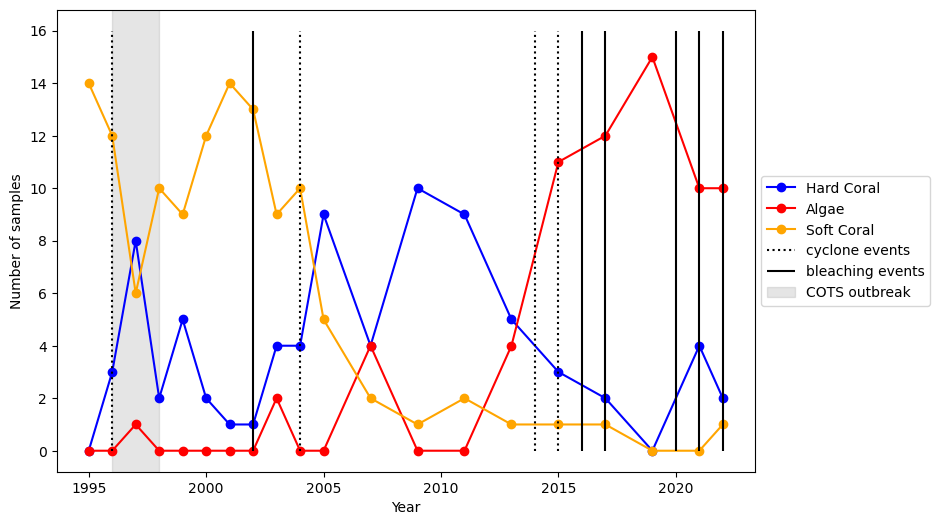

In [14]:
# Create a stacked area plot for specific clusters (2, 5, and 7)
#selected_clusters = [1, 2, 3]
# Define colors
colors = {'algae': 'red', 'soft coral & other': 'orange', 'hard coral': 'blue'}

plt.figure(figsize=(9, 6))
plt.plot(Cluster_freq['Year'], Cluster_freq['hard coral'], label='Hard Coral', color='blue', marker='o')
plt.plot(Cluster_freq['Year'], Cluster_freq['algae'], label='Algae', color='red', marker='o')
plt.plot(Cluster_freq['Year'], Cluster_freq['soft coral & other'], label='Soft Coral', color='orange', marker='o')

# multiple lines with varying ymin and ymax
plt.vlines(x=[1996, 2004, 2014, 2015], ymin=0, ymax=16,
           colors='black',
           linestyle='dotted',
           label='cyclone events')

# multiple lines with varying ymin and ymax
plt.vlines(x=[2002, 2016, 2017, 2020, 2021, 2022], ymin=0, ymax=16,
           colors='black',
           label='bleaching events')

# Add shaded grey horizontal block
plt.axvspan(ymin=0, ymax=16, xmin=1996, xmax=1998, color='gray', alpha=0.2, label='COTS outbreak')


plt.xlabel('Year')
plt.ylabel('Number of samples')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

# Save the plot as a JPEG file
plt.savefig('Frequency_of_clusters_main3.jpg', bbox_inches='tight')

plt.show()


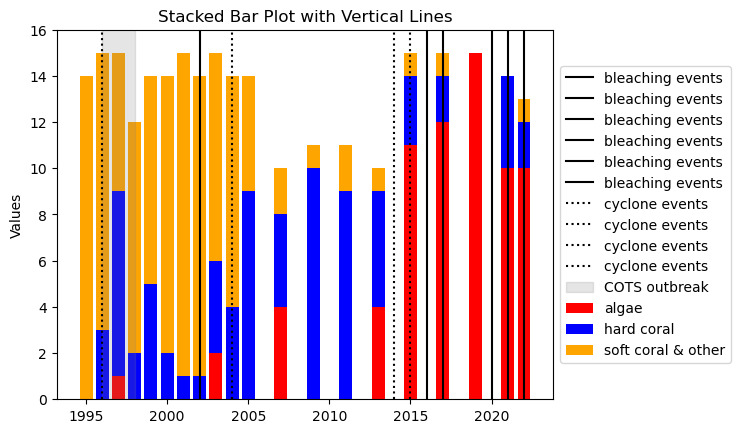

In [15]:
# Stacked bar plot
fig, ax = plt.subplots()
bar1 = ax.bar(Cluster_freq['Year'], Cluster_freq['algae'], color='red', label='algae')
bar2 = ax.bar(Cluster_freq['Year'], Cluster_freq['hard coral'], bottom=Cluster_freq['algae'], color='blue', label='hard coral')
bar3 = ax.bar(Cluster_freq['Year'], Cluster_freq['soft coral & other'], bottom=Cluster_freq['algae'] + Cluster_freq['hard coral'], color='orange', label='soft coral & other')

# add vertical lines
for year in [2002, 2016, 2017, 2020, 2021, 2022]:
    ax.axvline(x=year, ymin=0, ymax=16, color='black', label='bleaching events')

for year in [1996, 2004, 2014, 2015]:
    ax.axvline(x=year, ymin=0, ymax=16, color='black', linestyle='dotted', label='cyclone events')

# Add shaded grey horizontal block
ax.axvspan(ymin=0, ymax=16, xmin=1996, xmax=1998, color='gray', alpha=0.2, label='COTS outbreak')

# Customize the plot
ax.set_ylabel('Values')
ax.set_title('Stacked Bar Plot with Vertical Lines')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Set y-axis limit
ax.set_ylim(0, 16)

# Show the plot
plt.show()

In [16]:
# Perform PCA on Scaled Data
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_sp_scaled)
# Principal components correlation coefficients
loadings = pca.components_

# Get the list of column names as feature_name
feature_names = df_sp_scaled.columns.tolist()

# Number of features before PCA
n_features = pca.n_features_in_


X = df_sp_scaled
y = data_with_clusters['Cluster']

# Create DataFrame from PCA
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])

# Scale PCS into a DataFrame
pca_df_scaled = pca_df.copy()
 
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min())
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

pca_df_scaled['Cluster'] = y


In [17]:
# add defining names to clusters 
pca_df_scaled2 = pca_df_scaled
pca_df_scaled2['Cluster'] = pca_df_scaled2['Cluster'].replace({1: 'algae', 2: 'soft coral & other', 3: 'hard coral'})

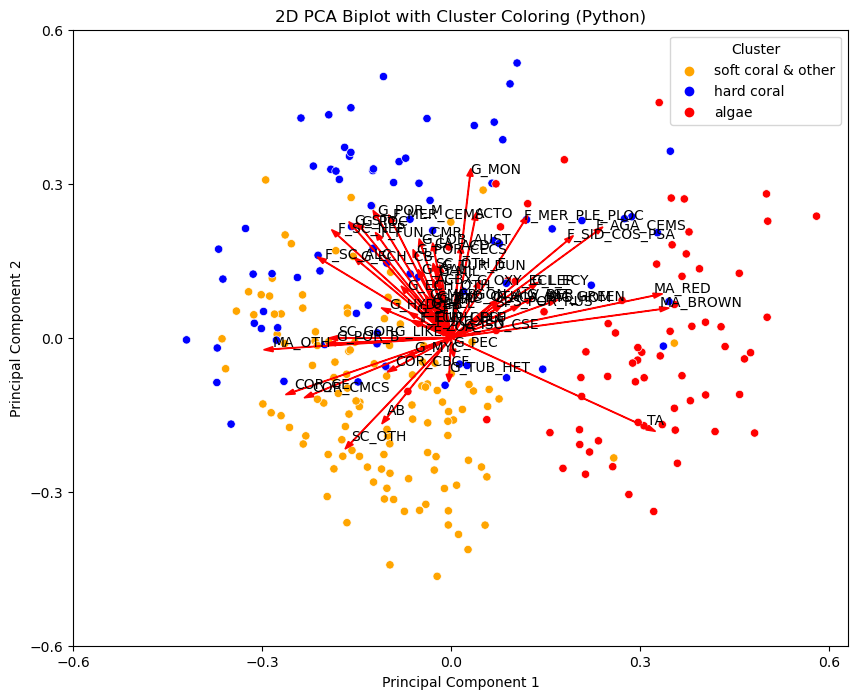

In [18]:
X = pca_df_scaled2
y = data_with_clusters['Cluster']

#define colours
colors = {'algae': 'red', 'soft coral & other': 'orange', 'hard coral': 'blue'}

# Create a figure and axes with the desired size
fig, ax = plt.subplots(figsize=(10, 8))

xs = loadings[0]
ys = loadings[1]


# Color the points based on the 'cluster' variable
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster',  # specify the cluster variable
    data=pca_df_scaled2, 
    ax=ax,
    palette=colors
)

for i, varnames in enumerate(feature_names):
    ax.arrow(
        0, 0,  # coordinates of arrow base
        xs[i],  # length of the arrow along x
        ys[i],  # length of the arrow along y
        color='r',
        head_width=0.01
    )
    ax.text(xs[i], ys[i], varnames, ha='left', va='bottom')  # Adjust text alignment

xticks = np.linspace(-0.6, 0.6, num=5)
yticks = np.linspace(-0.6, 0.6, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.title('2D PCA Biplot with Cluster Coloring (Python)')

# Save the plot as a PDF file
#plt.savefig('biplot_species.pdf')

plt.show()

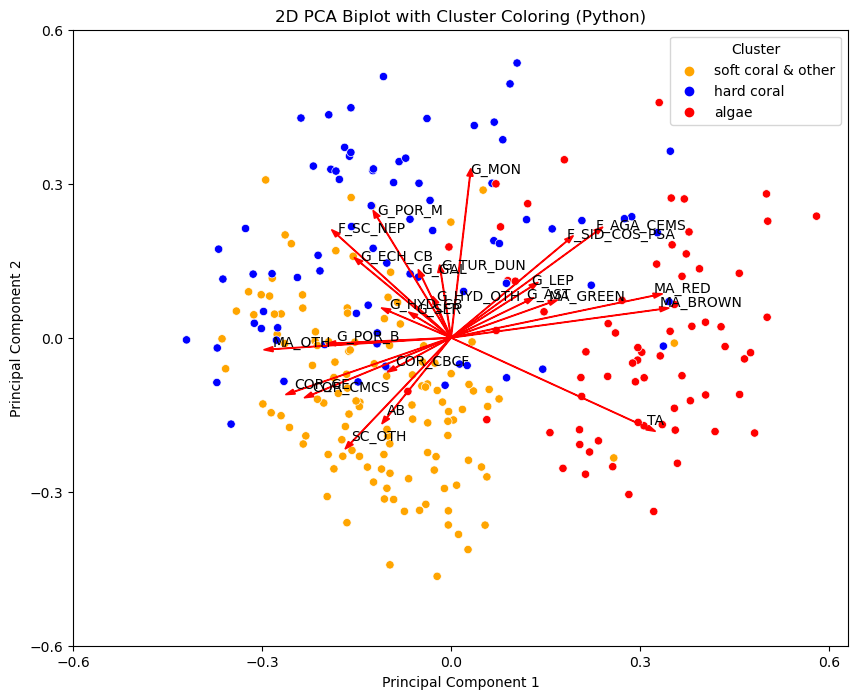

In [19]:
#create a biplot including only the top 8 species with highest average coverages within each cluster (based on the scaled coverages)

colors = {'algae': 'red', 'soft coral & other': 'orange', 'hard coral': 'blue'}

selected_columns = top_8species

# Create a figure and axes with the desired size
fig, ax = plt.subplots(figsize=(10, 8))

xs = loadings[0]
ys = loadings[1]


# Color the points based on the 'cluster' variable
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',  # specify the cluster variable
    data=pca_df_scaled2,
    ax=ax,
    palette=colors
)

for i, varnames in enumerate(feature_names):
    if varnames in selected_columns:
            ax.arrow(
                0, 0,  # coordinates of arrow base
                xs[i],  # length of the arrow along x
                ys[i],  # length of the arrow along y
                color='r',
                head_width=0.01
            )
            ax.text(xs[i], ys[i], varnames, ha='left', va='bottom')  # Adjust text alignment

xticks = np.linspace(-0.6, 0.6, num=5)
yticks = np.linspace(-0.6, 0.6, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.title('2D PCA Biplot with Cluster Coloring (Python)')

# Save the plot as a PDF file
plt.savefig('3biplot_species_thrsh_new.jpg', bbox_inches='tight')

plt.show()

In [20]:
# Summary of PCA
print(pd.DataFrame({'Standard deviation': np.sqrt(pca.explained_variance_),
                    'Proportion of Variance': pca.explained_variance_ratio_,
                    'Cumulative Proportion': np.cumsum(pca.explained_variance_ratio_)}))

   Standard deviation  Proportion of Variance  Cumulative Proportion
0            2.121089                0.078638               0.078638
1            1.928908                0.065033               0.143671


# Plotting all benthic cover

In [21]:
# Merge the two data sets to add year and site columns to our benthic coverage data
combined_df = pd.concat([df_fac_nout, df_sp_nout], axis=1)
df = combined_df.drop(columns=['Transect']) 

In [22]:
#Average by year
site_df = df.groupby(['Year', 'Site']).mean().reset_index()
year_df = site_df.groupby(['Year']).mean().reset_index()
year_df = year_df.drop(columns=['Site'])

# Set the Year column as the index (makes plotting easier)
year_df.set_index('Year', inplace=True)

In [23]:
#change order to group common species together
# List of columns to be moved to the end
columns_to_move = ["F_SC_ALC", "F_SC_NEP", "F_SC_XEN", "SC_OTH", "SC_OTH_E", "SC_GORG_LIKE", "SP", "ZOA", "CA", "MA_BROWN", "MA_RED", "MA_GREEN", "MA_OTH", "TA", "AB"]

# Identify the columns not in the specified list
remaining_columns = [col for col in year_df.columns if col not in columns_to_move]

# Reorder the DataFrame with the specified columns at the end
df_reordered = year_df[remaining_columns + columns_to_move]


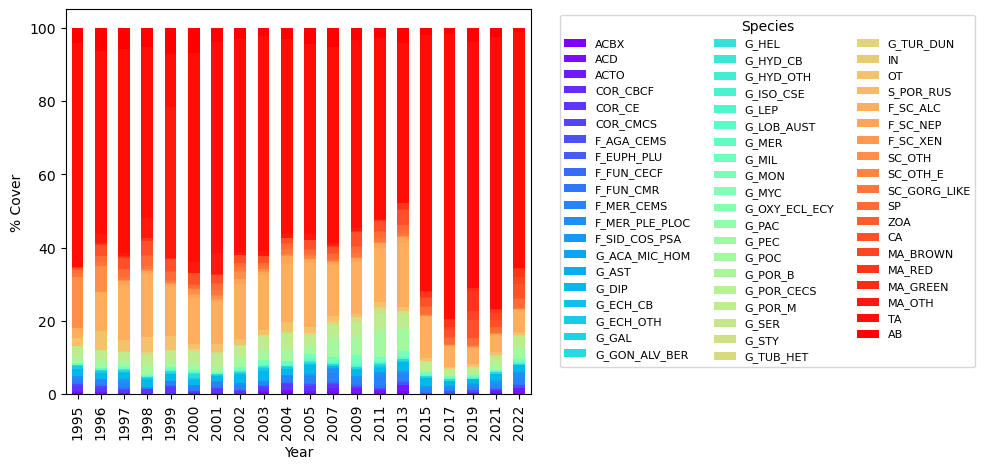

In [24]:
# plt.figure(figsize=(2, 2))
fig, ax0 = plt.subplots(1, 1, figsize=(6, 5))

# Create a stacked bar plot with the 'hsv' color palette
df_reordered.plot(kind='bar', stacked=True, colormap='rainbow',legend=True,ax=ax0)
# Set labels and title
# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('% Cover')
#plt.title('Stacked Bar Plot of Species by Year')
# Move the legend underneath and make it horizontal
plt.legend(title='Species', loc='upper left', ncol=3, bbox_to_anchor=(1.05, 1), fontsize=8)

# Show the plot
# plt.show()
# plt.tight_layout()
plt.savefig('spcomp.jpg', transparent=True, bbox_inches='tight')

plt.show()

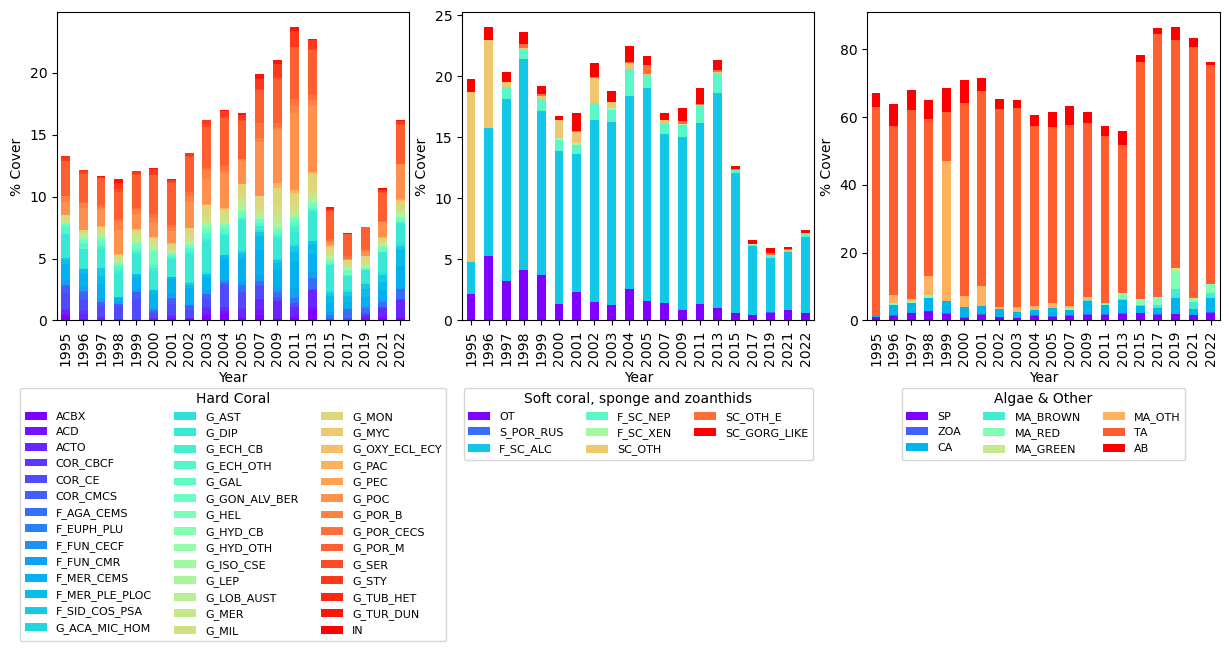

In [25]:
# Set the common labels
common_xlabel = 'Year'
common_ylabel = '% Cover'

fig, ax1 = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Hard Coral
df_subset1 = df_reordered.iloc[:, :42]
df_subset1.plot(kind='bar', stacked=True, colormap='rainbow', legend=True, ax=ax1[0])
ax1[0].set_xlabel(common_xlabel)
ax1[0].set_ylabel(common_ylabel)
ax1[0].legend(title='Hard Coral', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=8)

# Plot 2: Soft Coral, Sponge, and Zoanthids
df_subset2 = df_reordered.iloc[:, 42:50]
df_subset2.plot(kind='bar', stacked=True, colormap='rainbow', legend=True, ax=ax1[1])
ax1[1].set_xlabel(common_xlabel)
ax1[1].set_ylabel(common_ylabel)
ax1[1].legend(title='Soft coral, sponge and zoanthids', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=8)

# Plot 3: Algae & Other
df_subset3 = df_reordered.iloc[:, 50:59]
df_subset3.plot(kind='bar', stacked=True, colormap='rainbow', legend=True, ax=ax1[2])
ax1[2].set_xlabel(common_xlabel)
ax1[2].set_ylabel(common_ylabel)
ax1[2].legend(title='Algae & Other', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=8)

# Adjust layout to prevent overlap and make plots closer together
plt.subplots_adjust(wspace=0.15)

# Show the plot
plt.show()
